In [114]:
import pandas as pd
from Bio import Entrez
import urllib as ul
import seaborn as sns

Entrez.email = "a_polakof@ucsb.edu" 

In [63]:
df = pd.read_csv("SFARI-Gene_genes_09-02-2021release_11-22-2021export.csv")
human_df = pd.read_csv('Homo_sapiens.gene_info.gz', compression='gzip', header=0, sep='\t')

In [64]:
df.head()

,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
1,9,ABCA10,"ATP-binding cassette, sub-family A (ABC1), mem...",ENSG00000154263,17,Rare Single Gene Mutation,3.0,0,1
2,9,ABCA13,ATP binding cassette subfamily A member 13,ENSG00000179869,7,"Rare Single Gene Mutation, Functional",3.0,0,6
3,9,ABCA7,"ATP-binding cassette, sub-family A (ABC1), mem...",ENSG00000064687,19,Rare Single Gene Mutation,3.0,0,4
4,9,ACE,angiotensin I converting enzyme,ENSG00000159640,17,"Rare Single Gene Mutation, Genetic Association",3.0,0,3


In [65]:
gene_symbol_to_id_human = human_df.rename(columns={"Symbol": "gene-symbol"}).iloc[:, 1:3]
gene_symbol_to_id_human.head()

,GeneID,gene-symbol
0,1,A1BG
1,2,A2M
2,3,A2MP1
3,9,NAT1
4,10,NAT2


In [66]:
# Next we want to look at some of the functional terms that have been annotated to SFARI genes
# separating them out by their gene-score.

# Task 1 – Map the gene-symbol for every gene in the SFARI gene list to an NCBI UID (unique Entrez Gene identifier)(2)

# Use Homo_sapiens gene info for this.
df_ncbi_uid = df.copy()
df_ncbi_uid = df_ncbi_uid.merge(gene_symbol_to_id_human, on="gene-symbol")
df_ncbi_uid.head()

,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports,GeneID
0,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5,18
1,9,ABCA10,"ATP-binding cassette, sub-family A (ABC1), mem...",ENSG00000154263,17,Rare Single Gene Mutation,3.0,0,1,10349
2,9,ABCA13,ATP binding cassette subfamily A member 13,ENSG00000179869,7,"Rare Single Gene Mutation, Functional",3.0,0,6,154664
3,9,ABCA7,"ATP-binding cassette, sub-family A (ABC1), mem...",ENSG00000064687,19,Rare Single Gene Mutation,3.0,0,4,10347
4,9,ACE,angiotensin I converting enzyme,ENSG00000159640,17,"Rare Single Gene Mutation, Genetic Association",3.0,0,3,1636


In [67]:
print("Previous shape: ", df.shape)
print("Current shape with mapped gene list to NCBI UID: ", df_ncbi_uid.shape)

Previous shape:  (1023, 9)
Current shape with mapped gene list to NCBI UID:  (1018, 10)


In [68]:
# Task 2 – Using the gene2go file from NCBI that we worked with in week 8 find the Gene Ontology
# terms that have been annotated to all of the SFARI genes (4marks).

# ul.request.urlretrieve('https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz','gene2go.gz')
gene2go = pd.read_csv('gene2go.gz', compression='gzip', header=0, sep='\t')

In [69]:
# Restrict to human genes

human_gene2go = gene2go[gene2go['#tax_id']==9606]

human_sfari = pd.merge(df_ncbi_uid, human_gene2go, on="GeneID")[["GeneID", "GO_ID", "GO_term"]]

# drop duplicates 27389
human_sfari_unique = human_sfari[['GO_ID','GO_term']].drop_duplicates() # Do i need to drop duplicates?
# Gets how many times GO_ID was annotated to distinct genes 
# In other words, GO:0005515 was annotated in 711 different genes
human_sfari.groupby("GO_ID").count().iloc[:, 1].sort_values(ascending=False)

GO_ID
GO:0005515    711
GO:0005886    512
GO:0005634    502
GO:0005829    470
GO:0005654    418
             ... 
GO:0045047      1
GO:0045027      1
GO:0045010      1
GO:0045008      1
GO:0035932      1
Name: GO_term, Length: 6258, dtype: int64

In [70]:
human_sfari.groupby("GO_term").count().iloc[:, 1].sort_values(ascending=False)

GO_term
protein binding                                                                           711
plasma membrane                                                                           512
nucleus                                                                                   502
cytosol                                                                                   470
nucleoplasm                                                                               418
                                                                                         ... 
negative regulation of thrombin-activated receptor signaling pathway                        1
negative regulation of termination of RNA polymerase II transcription, poly(A)-coupled      1
negative regulation of telomeric RNA transcription from RNA pol II promoter                 1
negative regulation of telomere single strand break repair                                  1
negative regulation of delayed rectifier potassium c

In [71]:
# Task 3 – Now split the genes up into three lists by their SFARI gene-score (1 mark).

df_ncbi_grouped_by_gene_score= df_ncbi_uid.groupby("gene-score")

df_gene_score_1 = df_ncbi_grouped_by_gene_score.get_group(1.0)
df_gene_score_2 = df_ncbi_grouped_by_gene_score.get_group(2.0)
df_gene_score_3 = df_ncbi_grouped_by_gene_score.get_group(3.0)


In [80]:
# Task 4 – Create tables of the 10 most commonly annotated terms for each gene list.
# The tables should have the following columns: GO term ID, GO term Description, GO term count (3 marks)

# Now select 10 most commonly annotated terms
df_gs1_most_annotated = pd.merge(df_gene_score_1, human_gene2go, on="GeneID")[["GO_ID", "GO_term"]]
ps1 = df_gs1_most_annotated.groupby("GO_term").count().iloc[:,0]
df_gs1_most_annotated = pd.merge(df_gs1_most_annotated, ps1.to_frame(name="GO_term_count"), on="GO_term").drop_duplicates().sort_values(by=["GO_term_count"], ascending=False).iloc[:10, :]

df_gs2_most_annotated = pd.merge(df_gene_score_2, human_gene2go, on="GeneID")[["GO_ID", "GO_term"]]
ps2 = df_gs2_most_annotated.groupby("GO_term").count().iloc[:,0]
df_gs2_most_annotated = pd.merge(df_gs2_most_annotated, ps2.to_frame(name="GO_term_count"), on="GO_term").drop_duplicates().sort_values(by=["GO_term_count"], ascending=False).iloc[:10, :]

df_gs3_most_annotated = pd.merge(df_gene_score_3, human_gene2go, on="GeneID")[["GO_ID", "GO_term"]]
ps3 = df_gs3_most_annotated.groupby("GO_term").count().iloc[:,0]
df_gs3_most_annotated = pd.merge(df_gs3_most_annotated, ps3.to_frame(name="GO_term_count"), on="GO_term").drop_duplicates().sort_values(by=["GO_term_count"], ascending=False).iloc[:10, :]


In [82]:
df_gs1_most_annotated

,GO_ID,GO_term,GO_term_count
47,GO:0005515,protein binding,161
248,GO:0005634,nucleus,155
403,GO:0005654,nucleoplasm,133
610,GO:0005829,cytosol,97
719,GO:0005886,plasma membrane,94
536,GO:0005737,cytoplasm,74
2144,GO:0045944,positive regulation of transcription by RNA po...,68
1140,GO:0000981,"DNA-binding transcription factor activity, RNA...",51
1262,GO:0006357,regulation of transcription by RNA polymerase II,49
1968,GO:0000122,negative regulation of transcription by RNA po...,48


In [84]:
df_gs2_most_annotated

,GO_ID,GO_term,GO_term_count
16,GO:0005515,protein binding,150
348,GO:0005886,plasma membrane,125
210,GO:0005634,nucleus,114
675,GO:0005829,cytosol,109
1179,GO:0005654,nucleoplasm,92
928,GO:0005737,cytoplasm,86
525,GO:0016020,membrane,39
1634,GO:0098978,glutamatergic synapse,38
1362,GO:0003723,RNA binding,38
1014,GO:0005887,integral component of plasma membrane,34


In [85]:
df_gs3_most_annotated

,GO_ID,GO_term,GO_term_count
1471,GO:0005515,protein binding,340
503,GO:0005886,plasma membrane,262
2163,GO:0005829,cytosol,220
1811,GO:0005634,nucleus,185
1996,GO:0005737,cytoplasm,167
2811,GO:0005654,nucleoplasm,152
2637,GO:0005887,integral component of plasma membrane,96
387,GO:0016021,integral component of membrane,87
3261,GO:0016020,membrane,75
240,GO:0046872,metal ion binding,68


In [127]:
# Task 5 – Take the three lists of UIDs created above and use the PantherDB tool -
# http://pantherdb.org/ to perform a “Functional classification viewed in graphic charts” analysis reporting 
# and select the “Bar chart” display option, using default settings. Once on the results page displaying 
# the bar chart use the pull-down menu to change the ontology to “Biological Process”. 
# Click the small (!) “export” button to download the results as a text file and us this to make your own bar chart 
# (5 marks).

def write_uids_to_file(df, file_name):
    textfile = open(file_name, "w")
    for row in df.iterrows():
        textfile.write(str(row[1]["GeneID"]) + "\n")
    textfile.close()
    
write_uids_to_file(df_gene_score_1, "df_gs1_most_annotated.txt")
write_uids_to_file(df_gene_score_2, "df_gs2_most_annotated.txt")
write_uids_to_file(df_gene_score_3, "df_gs3_most_annotated.txt")

In [144]:
# Read txt files of Panther DB so that we can plot them

df_pantherchart_score_1 = pd.read_csv("pantherChart_gs1.txt", sep="	", header=None).iloc[:, 1:3].rename(columns={1:"Go Biological Process", 2:"count"}).sort_values(by="count", ascending=False)
df_pantherchart_score_2 = pd.read_csv("pantherChart_gs2.txt", sep="	", header=None).iloc[:, 1:3].rename(columns={1:"Go Biological Process", 2:"count"}).sort_values(by="count", ascending=False)
df_pantherchart_score_3 = pd.read_csv("pantherChart_gs3.txt", sep="	", header=None).iloc[:, 1:3].rename(columns={1:"Go Biological Process", 2:"count"}).sort_values(by="count", ascending=False)

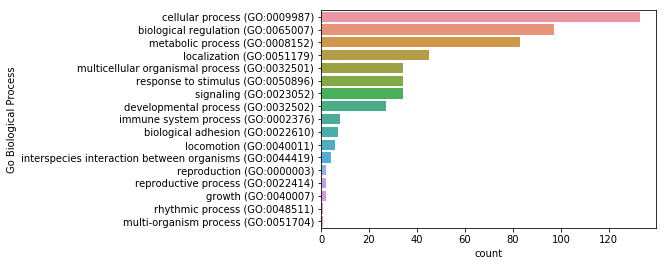

In [145]:
sns.barplot(x="count", y="Go Biological Process", data=df_pantherchart_score_1)

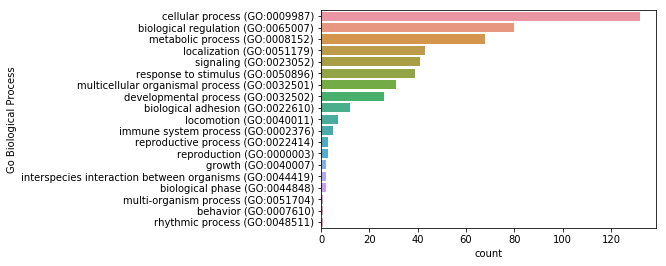

In [146]:
sns.barplot(x="count", y="Go Biological Process", data=df_pantherchart_score_2)

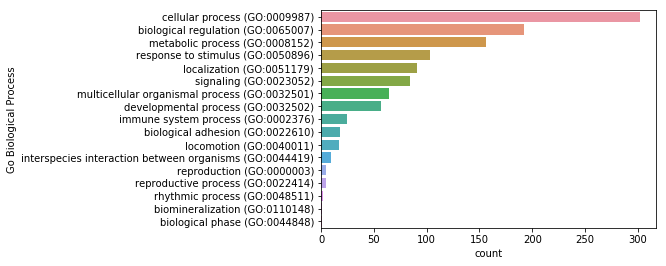

In [147]:
sns.barplot(x="count", y="Go Biological Process", data=df_pantherchart_score_3)

In [135]:
df_pantherchart_score_1.head()

,Go Biological Process,count
0,cellular process (GO:0009987),133
1,reproductive process (GO:0022414),2
2,multi-organism process (GO:0051704),1
3,localization (GO:0051179),45
4,interspecies interaction between organisms (GO...,4


In [ ]:
# Part Three - Create a plain text file of the NCBI UIDs for all of the gene-score 1 SFARI gene

ncbi_uids_score_1 = list(df_gene_score_1["GeneID"])

textfile = open("ncbi_uids_score_1.txt", "w")
for element in ncbi_uids_score_1:
    textfile.write(str(element) + "\n") 
textfile.close()

In [ ]:
# Then, using the STRING website (https://string-db.org/) upload the gene-score 1 gene list, select “homo sapiens” 
# In this network the genes are the nodes and the interactions between them the edges (connections). 
# Click the “analysis” option near the bottom and report the following statistics: 
# “number of nodes”, “number of edges” and “average node degree” (3 marks).

# number of nodes:	206
# number of edges:	1404
# average node degree:	13.6
# avg. local clustering coefficient:	0.438
# expected number of edges:	408
# PPI enrichment p-value:	< 1.0e-16
# your network has significantly more interactions
# than expected (what does that mean?)

# This means that your proteins have more interactions among themselves than what would be expected for a 
# random set of proteins of the same size and degree distribution drawn from the genome. 
# Such an enrichment indicates that the proteins are at least partially biologically connected, as a group.

In [60]:
def write_prot_name_to_file(df, file_name):
    textfile = open(file_name, "w")
    for row in df.iterrows():
        textfile.write(str(row[1]["protein name"]) + "\n")
    textfile.close()

In [61]:
# Task 2

# Click the “cluster” option and select “MCL clustering” with the default option. 
# Download the “MCL clusters in TSV format” file. 
# From this, find the two biggest clusters produced by the MCL clustering and 
# use the PantherDB tool as in Part Two to analyse the function of genes in these clusters.
# This time instead of selecting “Biological Process” ontology use the “Pathway” ontology (6 marks)

cluster_df = pd.read_csv("string_MCL_clusters.tsv", sep="\t")

# Two biggest clusters are 1 and 2

clusters_1_2_df = cluster_df[(cluster_df["cluster number"] == 1) | (cluster_df["cluster number"] == 2)]

write_prot_name_to_file(clusters_1_2_df, "MCL_clusters_proteins.txt")

In [ ]:
# Task 3
# Click the “exports” option and download the network as a “bitmap image” file (1 mark).